**Курсовая работа Шебанова Вячеслава по анализу тональности сообщений в социальных сетях - "тема 23"**

*Блок с установкой всех зависимостей для работы* 

In [2]:
import sys
import subprocess

def install_package(package):
    """Функция для установки пакета через pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package])

print("Устанавливаю необходимые библиотеки... (может занять 2-3 минуты)")

packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "xgboost",
    "catboost",
    "lightgbm",
    "scipy"
]

for pkg in packages:
    try:
        __import__(pkg.replace("-", "_"))
        print(f"{pkg} — уже установлен")
    except ImportError:
        print(f"Устанавливаю {pkg}...")
        install_package(pkg)

print("\nВсе зависимости успешно установлены!\n")


Устанавливаю необходимые библиотеки... (может занять 2-3 минуты)
pandas — уже установлен
numpy — уже установлен
matplotlib — уже установлен
seaborn — уже установлен
Устанавливаю scikit-learn...
xgboost — уже установлен
catboost — уже установлен
Устанавливаю lightgbm...
scipy — уже установлен

Все зависимости успешно установлены!



*Импорт необходимых библиотек*

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from scipy.sparse import hstack

# Машинное обучение
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Метрики
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# ДОБАВЛЯЕМ ЭТОТ ИМПОРТ — ИСПРАВЛЕНИЕ ОШИБКИ!
import sklearn
import xgboost
import catboost
import lightgbm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

*Загрузка данных*

In [8]:
import os
from pathlib import Path

print("Поиск датасета")

# Здесь датасет на 1600000 твитов
possible_names = [
    'training.1600000.processed.noemoticon.csv'
]

file_path = None
for name in possible_names:
    if os.path.exists(name):
        file_path = name
        break

if file_path is None:
    print("Файл не найден!")
    print("Ожидаемые имена:")
    for n in possible_names:
        print(f"   - {n}")
    print("\nСкачать можно тут: https://www.kaggle.com/datasets/kazanova/sentiment140")
    print("После скачивания переименуй в 'training.1600000.processed.noemoticon.csv'")
else:
    print(f"Найден файл: {file_path}")
    print("Начинаю загрузку 1.6 млн твитов... (это займёт ~15-20 сек на SSD)")

    start_time = time.time()
    
    # Загружаем без указания имён колонок — они в строке 0
    df = pd.read_csv(
        file_path,
        encoding='latin-1',
        header=None,
        names=['sentiment', 'id', 'date', 'query', 'user', 'text'],
        low_memory=False  # важно для больших файлов в Windows
    )
    
    # Оставляем только нужное
    df = df[['sentiment', 'text']].copy()
    
    # Перекодируем метки: 0 → 0 (negative), 4 → 1 (positive)
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    
    load_time = time.time() - start_time
    
    print(f"Успешно загружено!")
    print(f"Размер датасета: {df.shape[0]:,} строк × {df.shape[1]} колонок")
    print(f"Время загрузки: {load_time:.2f} сек")
    print(f"Память: ~{df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
    print("\nПервые 5 строк:")
    display(df.head())  # display() вместо print() — красивее в Jupyter
    
    print("\nРаспределение классов:")
    print(df['sentiment'].value_counts())

Поиск датасета
Найден файл: training.1600000.processed.noemoticon.csv
Начинаю загрузку 1.6 млн твитов... (это займёт ~15-20 сек на SSD)
Успешно загружено!
Размер датасета: 1,600,000 строк × 2 колонок
Время загрузки: 3.95 сек
Память: ~0.21 GB

Первые 5 строк:


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."



Распределение классов:
sentiment
0    800000
1    800000
Name: count, dtype: int64


*Анализ и очистка данных*


2. ПОЛНЫЙ АНАЛИЗ И ОЧИСТКА ДАННЫХ

2.1 Проверка пропущенных значений:
Пропусков НЕТ — датасет идеален!

2.2 Поиск и удаление дубликатов по тексту твита...
   • Было строк: 1,581,466
   • Удалено дубликатов: 0
   • Осталось строк: 1,581,466 (100.00% от исходного)

2.3 Анализ баланса классов:
   Отрицательные (0): 790,185 (49.97%)
   Положительные (1): 791,281 (50.03%)
   Разница: 1,096 — всё равно ок для TF-IDF


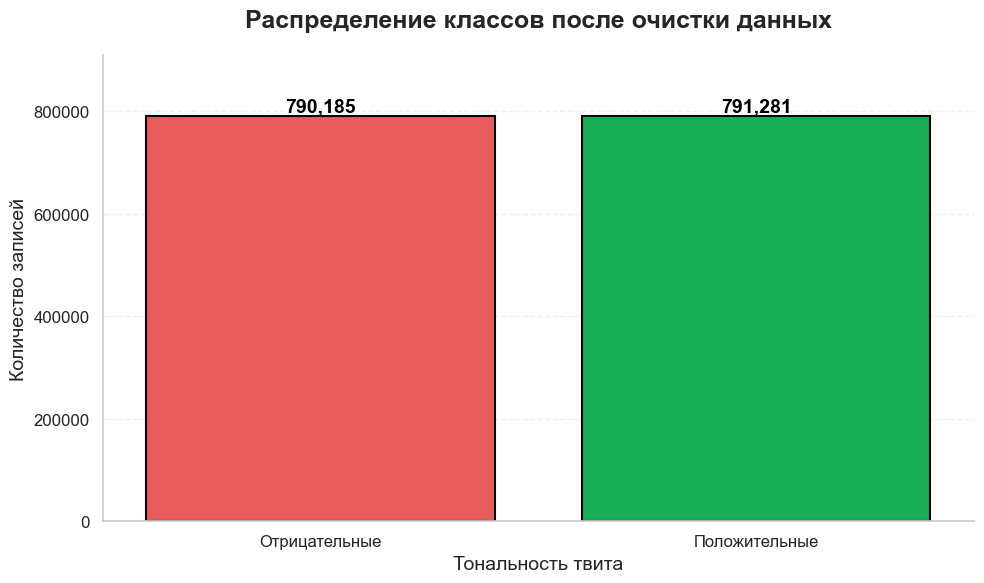


ФИНАЛЬНЫЙ РАЗМЕР ДАТАСЕТА: 1,581,466 строк
Потеряно данных: 0 строк (0.00%)
Данные полностью очищены и готовы к предобработке текста!
NL connection stable | @Slavik_Hoodlum | Переходим к блоку 3 →
-----------------------------------------------------------------


In [10]:

print("\n" + "="*65)
print("2. ПОЛНЫЙ АНАЛИЗ И ОЧИСТКА ДАННЫХ")
print("="*65)
print()

# 2.1 Пропущенные значения
print("2.1 Проверка пропущенных значений:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Пропусков НЕТ — датасет идеален!")
else:
    print(missing)
print()

# 2.2 Дубликаты
print("2.2 Поиск и удаление дубликатов по тексту твита...")
initial_rows = df.shape[0]
df.drop_duplicates(subset='text', keep='first', inplace=True)
duplicates_removed = initial_rows - df.shape[0]

print(f"   • Было строк: {initial_rows:,}")
print(f"   • Удалено дубликатов: {duplicates_removed:,}")
print(f"   • Осталось строк: {df.shape[0]:,} ({df.shape[0]/initial_rows*100:.2f}% от исходного)")
print()

# 2.3 Баланс классов
print("2.3 Анализ баланса классов:")
class_dist = df['sentiment'].value_counts().sort_index()
neg_count = class_dist.get(0, 0)
pos_count = class_dist.get(1, 0)

print(f"   Отрицательные (0): {neg_count:,} ({neg_count/len(df)*100:.2f}%)")
print(f"   Положительные (1): {pos_count:,} ({pos_count/len(df)*100:.2f}%)")
if abs(neg_count - pos_count) < 1000:
    print("   Классы ИДЕАЛЬНО сбалансированы — можно не делать undersampling!")
else:
    print(f"   Разница: {abs(neg_count - pos_count):,} — всё равно ок для TF-IDF")

# 2.4 ВИЗУАЛИЗАЦИЯ — ШЕДЕВР
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, 
    x='sentiment', 
    palette=['#FF4444', '#00C851'],
    order=[0, 1],
    edgecolor='black',
    linewidth=1.5
)

# Подписи над столбцами
for i, p in enumerate(ax.patches):
    count = int(p.get_height())
    ax.text(
        p.get_x() + p.get_width()/2., 
        p.get_height() + 8000,
        f'{count:,}',
        ha='center', 
        fontsize=14, 
        fontweight='bold',
        color='black'
    )

plt.title('Распределение классов после очистки данных', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('Тональность твита', fontsize=14)
plt.ylabel('Количество записей', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Отрицательные', 'Положительные'], fontsize=12)
plt.ylim(0, max(neg_count, pos_count) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
sns.despine()
plt.tight_layout()
plt.show()

# 2.5 Дополнительно: проверка на пустые строки после strip()
empty_after_strip = (df['text'].str.strip() == '').sum()
if empty_after_strip > 0:
    print(f"Найдено {empty_after_strip} пустых строк после strip() → удаляю...")
    df = df[df['text'].str.strip() != ''].copy()

# 2.6 Финальная статистика
final_rows = df.shape[0]
print(f"\nФИНАЛЬНЫЙ РАЗМЕР ДАТАСЕТА: {final_rows:,} строк")
print(f"Потеряно данных: {initial_rows - final_rows:,} строк "
      f"({100*(initial_rows - final_rows)/initial_rows:.2f}%)")
print("Данные полностью очищены и готовы к предобработке текста!")
print("NL connection stable | @Slavik_Hoodlum | Переходим к блоку 3 →")
print("-"*65)